# HH simulation


## Table of Contents 

* Defining equations of motion
* Plotting solution 
* Plotting 2-D trajectories 

## Setup

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
# Setting plotting defaults

# Make legend text small
plt.rcParams['legend.fontsize'] = 'small' 
# Shrink axes labels a bit 
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['xtick.labelsize'] = 'small'
plt.rcParams['ytick.labelsize'] = 'small'
# Set limits on when scientific notation is used
plt.rcParams['axes.formatter.limits'] = [-2, 3] 
# Use LaTeX to format axes labels and numbers
plt.rcParams['axes.formatter.use_mathtext'] = True
# Get rid of spines on top and bottom
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
# Ticks point in  
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
# Change DPI of figure images
plt.rcParams['figure.dpi'] = 300

## Defining equations of motion

There are 4 variables in the HH model 

1. $V$ (membrane voltage)
2. $n$ (activation gate for K+ channel)
3. $m$ (activation gate for Na+ channel)
4. $h$ (inactivation gate for Na+ channel)

albeit with different constants depending on the gate. 

Note that in the original HH paper they had a different definition of Voltage:

$$ V_{HH} = -V + 65 $$

In [89]:
# Functions defining external current

## A static current
def static_i(t, i_0=0):
    return(i_0) 

## A step current
def step_i(t, t_s=10, t_f=200, i_max=0.03):
    if (t>=t_s) & (t<t_f):
        return i_max
    else:
        return 0

# Setting paramaters

## External current function (in micro-A/mm^2)
i = step_i

## Capacitance (in micro-F/mm^2)
c = 0.010

## Conductances (in mS/mm^2)
gL = 0.003
gK = 0.036
gNa = 1.2

## Reversal potentials (in mV)
eL = -70
eK = -77
eNa = 50

# Membrane voltage dynamics
def dVdt(V, n, m, h, t):
    i_m = gL*(V-eL) + gK*(n**4)*(V-eK) + gNa*(m**3)*h*(V-eNa) 
    return((-i_m + i(t)) / c)

# Voltage-gated channel subunit dynamics
def dndt(V, n):
    alpha = 0.01*(V + 55) / (1 - np.exp(-0.1*(V + 55)))
    beta = 0.125*np.exp(-0.0125*(V + 65))
    delta = alpha*(1.0-n) - beta*n
    if (delta > 1.-n) or (n>1.):
        delta = 1.-n
    elif (delta < -n) or (n<0):
        delta = -n
    return(delta) 

def dmdt(V, m):
    alpha = 0.1*(V + 40) / (1 - np.exp(-0.1*(V + 40)))
    beta = 4*np.exp(-0.0556*(V + 65))
    delta = alpha*(1.0-m) - beta*m
    if (delta > 1.-m) or (m>1.):
        delta = 1. - m
    elif (delta < -m) or (m<0.):
        delta = -m
    return(delta) 

def dhdt(V, h):
    alpha = 0.07*np.exp(-0.05*(V + 65))
    beta = 1 / (1 + np.exp(-0.1*(V + 35)))
    delta = alpha*(1.0-h) - beta*h
    if (delta > 1.-h) or (h>1.):
        delta = 1.-h
    elif (delta < -h) or (h<0.):
        delta = -h
    return(delta) 

# Putting all the dynamics together into one function
def dSdt(V, n, m, h, t):
    return(np.array([dVdt(V, n, m, h, t), dndt(V, n), dmdt(V, m), dhdt(V, h), 1.]))

In [90]:
# Simulation functions 
DT = 0.1

# Function implimenting the midpoint method aka RK2
def find_next_point_midpoint(s, dsdt, dt=DT):
    s_test = s + dsdt(*s)*dt
    s_next = s + dsdt(*((s + s_test)/2.))*dt
    return(s_next)

# Simulation function
def simulate(s_0, t_f, dsdt=dSdt, simulation_function=find_next_point_midpoint, dt=DT, verbose=False):
    S_solution = [s_0]
    T = np.arange(s_0[-1], t_f + dt, dt)
    for t in T[1:]:
        s_previous = S_solution[-1]
        s_next = simulation_function(s_previous, dsdt, dt=dt)
        if verbose:
            print(s_next)
        S_solution.append(s_next)
    S_solution = np.array(S_solution)
    return(S_solution)

In [91]:
# Function to find action potential times
from scipy.signal import find_peaks

def AP_times(V, T, dt=DT):
    return(T[find_peaks(V, threshold=0, width=int(1./dt))[0]])

## Plotting a solution

In [92]:
## starting values for V, n, m, h, t
S_0 = [-80, 0, 0, 0, 0]

## Final value for T
T = 100 # in ms

## Simulating all other time points
S = simulate(S_0, T, verbose=False)

In [93]:
## Saving out simulation results as individual variables
V = S[:,0]
n = S[:,1]
m = S[:,2]
h = S[:,3]
T = S[:,4]

Text(0.5, 0, 'Time (ms)')

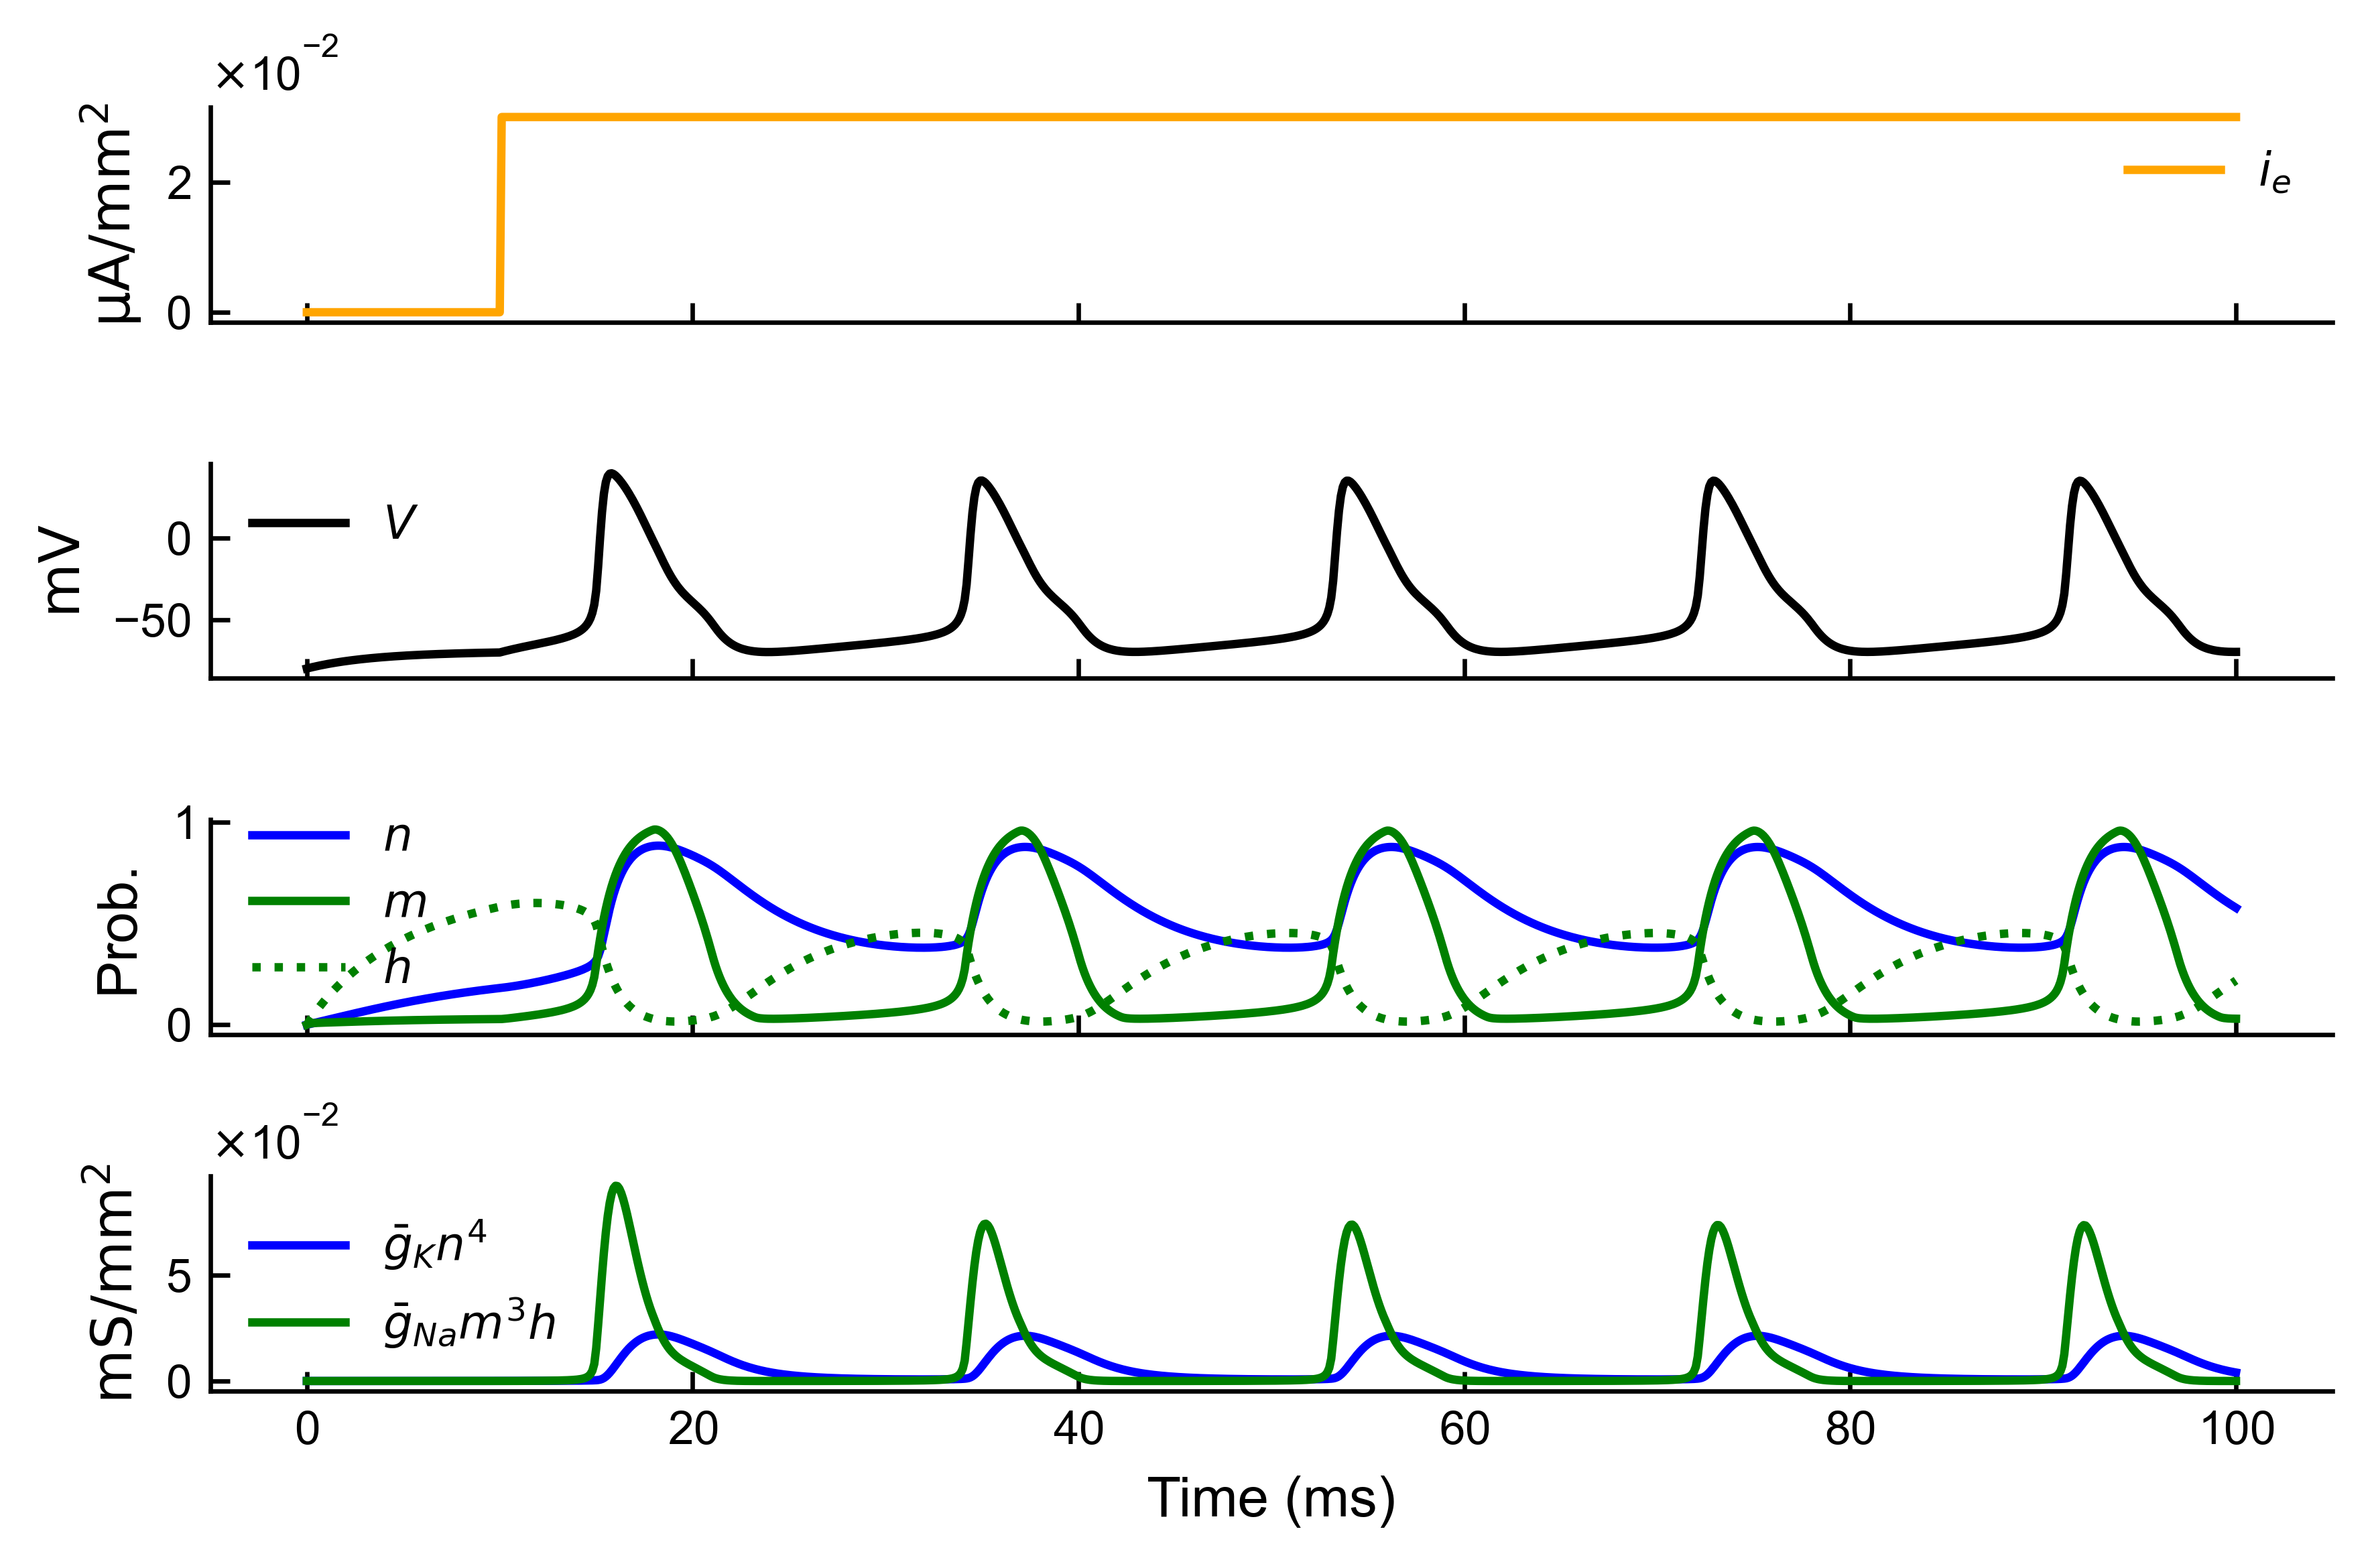

In [94]:
fig, (ax_i, ax_v, ax_c, ax_c2) = plt.subplots(nrows=4, sharex=True)

## Plotting current
ax_i.plot(T, [i(t) for t in T], c='orange', label="$i_e$")
ax_i.legend()
ax_i.set_ylabel("$\\mathrm{\mu A}/\\mathrm{mm^2}$")

## Plotting membrane voltage
ax_v.plot(T, V, c='k', label="$V$")
ax_v.legend()
ax_v.set_ylabel("$\\mathrm{mV}$")

## Plotting activation and inactivation gates
ax_c.plot(T, n, c='blue', label="$n$")
ax_c.plot(T, m, c='green', label="$m$")
ax_c.plot(T, h, c='green', ls=':', label="$h$")
ax_c.legend()
ax_c.set_ylabel("Prob.")

## Plotting conductances
ax_c2.plot(T, gK*n**4, c='blue', label="$\\bar{g}_{K} n^4$")
ax_c2.plot(T, gNa*m**3*h, c='green', label="$\\bar{g}_{Na} m^3h$")
ax_c2.legend()
ax_c2.set_ylabel("$\\mathrm{mS}/\\mathrm{mm}^2$")

ax_c2.set_xlabel("Time (ms)")

In [95]:
# Finding the action potential times
AP_times(V, T)

array([15.8, 35. , 53.9, 72.9, 91.9])

## 2-D trajectories 

Text(0.5, 0, 'h')

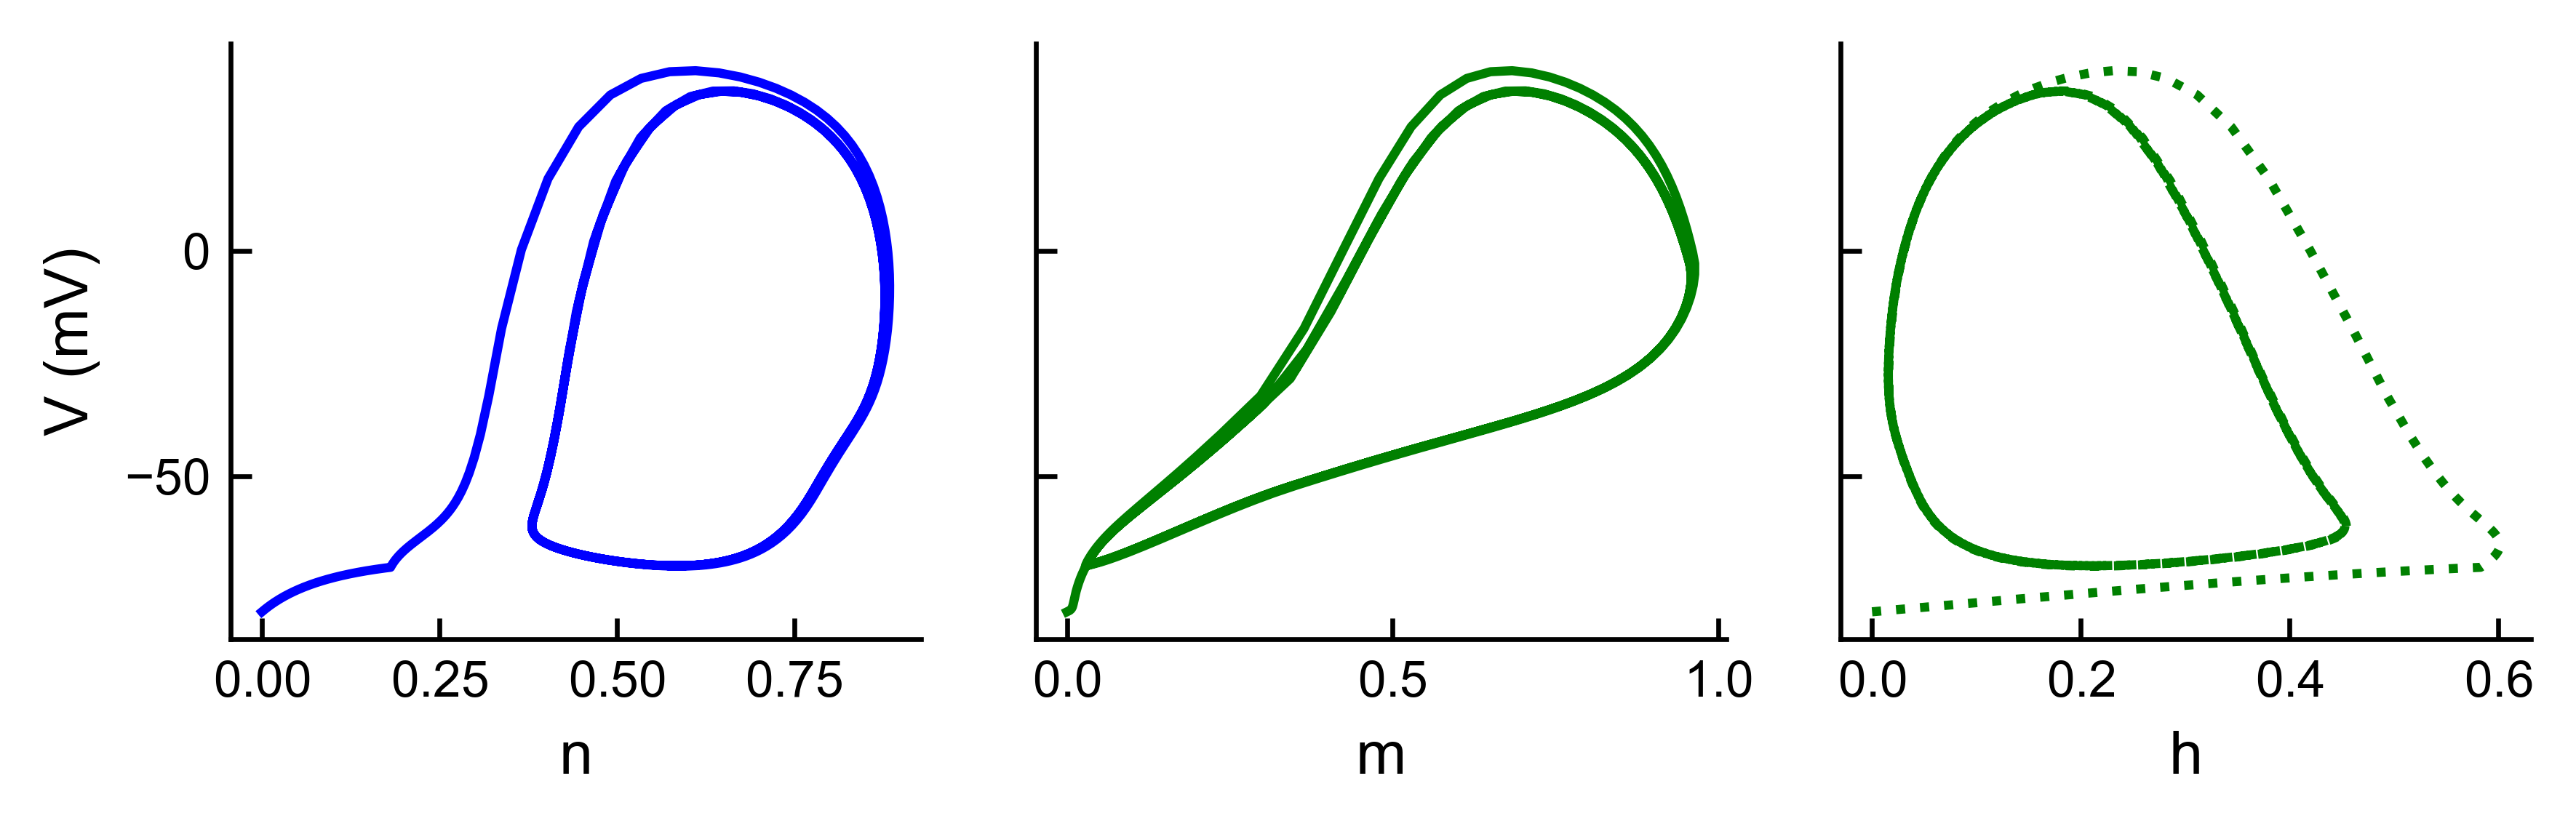

In [104]:
fig, (ax_n, ax_m, ax_h) = plt.subplots(ncols=3, sharey=True, figsize=(6,2))

ax_n.plot(n, V, c='blue')
ax_n.set_ylabel("V (mV)")
ax_n.set_xlabel("n")

ax_m.plot(m, V, c="green")
ax_m.set_xlabel("m")

ax_h.plot(h, V, c="green", ls=":")
ax_h.set_xlabel("h")
